# Figure 2: Effect of aperture placement

This is the code used to create **Figure 2** in the **Apples with Apples** paper (Bonse et al. in prep). The Figure shows the effect of the aperture placement on the SNR and p-value of the T-Test. In this example we rotate the aperture positions and study how the SNR changes as a function of the rotation

## Imports

In [1]:
import os
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import numpy as np
from numpy import radians as rad
import pandas as pd
import seaborn as sns
import json
from scipy import stats
import matplotlib.patches as patches

from applefy.statistics import TTest, fpf_2_gaussian_sigma
from applefy.utils.data_handling import read_apples_with_apples_root, open_fits
from applefy.utils import center_subpixel, estimate_reference_positions, AperturePhotometryMode,\
    IterNoiseForPlanet, get_flux

## Data loading

We need to load two example residuals (after using PCA) which contain previously inserted artifical companion. Later for the computation of the contrast grid in **Figure 7** we compute several of such residuals. We use two of these residuals as an example here.

In order to run the code **make sure to download the data from Zenodo and [read the instructions](../02_paper_data.md) on how to setup the files**.

In [2]:
experiment_root = read_apples_with_apples_root()

Data in the APPLES_ROOT_DIR found. Location: /Users/markusbonse/Desktop/


First, we read in the two example residuals from their .fits files.

In [3]:
fake_planet_residual_path_1 = os.path.join(
    experiment_root, 
    "70_results/detection_limits/Beta_Pic_non_stacked/pca_residuals/pca_030_ID_0083c.fits")

fake_planet_residual_path_2 = os.path.join(
    experiment_root, 
    "70_results/detection_limits/Beta_Pic_non_stacked/pca_residuals/pca_030_ID_0149a.fits")

planet_residual_1 = open_fits(fake_planet_residual_path_1)
planet_residual_2 = open_fits(fake_planet_residual_path_2)

In additon we need to know the position of the inserted fake planets which are given in the config files.

In [4]:
# Set the paths
fake_planet_config_path_1 = os.path.join(
     experiment_root, 
    "70_results/detection_limits/Beta_Pic_non_stacked/configs_cgrid/exp_ID_0083c.json")

fake_planet_config_path_2 = os.path.join(
     experiment_root, 
    "70_results/detection_limits/Beta_Pic_non_stacked/configs_cgrid/exp_ID_0149a.json")

# Open the json files
with open(fake_planet_config_path_1) as json_file:
    fake_planet_config_1 = json.load(json_file)

with open(fake_planet_config_path_2) as json_file:
    fake_planet_config_2 = json.load(json_file)

# Read out the planet positions
# The last two values in "planet_position" are the separation from the star and the position angle
planet_position_1 = fake_planet_config_1["planet_position"][:2]
planet_position_2 = fake_planet_config_2["planet_position"][:2]

## Computation of the SNR variation

We want to compute the SNR ($T_{\text{obs}}$) as well as the detection confidence ($\sigma_{\mathcal{N}}$) for different rotated aperture positions. The function [compute_detection_confidence](../../04_package/detections.rst#applefy.detections.evaluation.compute_detection_confidence) in applefy automatically calculates by how much we have to rotate our apertures until the rotated positions match again with the initial ones. The required total rotation is dependent on the separation from the star (e.g. 60 deg at 1 $\lambda /D$).

In Figure 2 we show the effect for a fixed total rotation of 60 deg which is why we slightly modify the function in applefy.

In [5]:
def compute_detection_confidence_60deg(
    frame, # the residual image
    planet_position,
    psf_fwhm_radius,
    photometry_mode_planet: AperturePhotometryMode,
    photometry_mode_noise: AperturePhotometryMode,
    num_rot_iter=20,
    safety_margin=1.0):
    
    # 0.) setup a TTest
    test_statistic = TTest()

    # 1.) make sure the photometry modes are compatible
    photometry_mode_planet.check_compatible(photometry_mode_noise)

    # 2.) estimate the planet flux
    planet_photometry = get_flux(frame=frame,
                                 position=planet_position,
                                 photometry_mode=photometry_mode_planet)[1]

    # 3.) Iterate over the noise
    noise_iterator = IterNoiseForPlanet(
        residual=frame,
        planet_position=planet_position[:2],
        safety_margin=safety_margin,
        psf_fwhm_radius=psf_fwhm_radius,
        num_iterations=num_rot_iter,
        max_rotation=60, # the fixed 60 deg of rotation
        photometry_mode=photometry_mode_noise)

    t_values = []
    p_values = []

    # The IterNoiseForPlanet class takes care of rotating the aperture positions 
    # and extracting the noise values. 
    for tmp_noise_sample in noise_iterator:
        test_result = test_statistic.test_2samp(planet_photometry,
                                                tmp_noise_sample)

        p_values.append(test_result[0])
        t_values.append(test_result[1])

    return np.median(p_values), np.array(p_values), np.array(t_values)

As in [Figure 1](01_What_is_a_detection.ipynb) we use the [AperturePhotometryMode](../../04_package/utils.rst#applefy.utils.aperture_photometry.AperturePhotometryMode) "ASS" and "AS" to compute the aperture averages.

In [6]:
photometry_mode_planet = AperturePhotometryMode("ASS", psf_fwhm_radius=2.1, search_area=0.5)
photometry_mode_noise = AperturePhotometryMode("AS", psf_fwhm_radius=2.1)

Compute the SNR and p-values for both residuals as a function of the rotation.

In [7]:
_, p_values_1, t_values_1 = compute_detection_confidence_60deg(
    planet_residual_1,
    planet_position_1, 
    psf_fwhm_radius=2.1,
    photometry_mode_planet=photometry_mode_planet,
    photometry_mode_noise=photometry_mode_noise,
    num_rot_iter=50,
    safety_margin=1.0)

p_values_sigma_1 = fpf_2_gaussian_sigma(p_values_1)

_, p_values_2, t_values_2 = compute_detection_confidence_60deg(
    planet_residual_2,
    planet_position_2, 
    psf_fwhm_radius=2.1,
    photometry_mode_planet=photometry_mode_planet,
    photometry_mode_noise=photometry_mode_noise,
    num_rot_iter=50,
    safety_margin=1.0)

p_values_sigma_2 = fpf_2_gaussian_sigma(p_values_2)

Collect the minimum and maximum p-values.

In [8]:
min_p_1 = np.min(p_values_sigma_1)
max_p_1 = np.max(p_values_sigma_1)
min_t_1 = np.min(t_values_1)
max_t_1 = np.max(t_values_1)

In [9]:
min_p_2 = np.min(p_values_sigma_2)
max_p_2 = np.max(p_values_sigma_2)
min_t_2 = np.min(t_values_2)
max_t_2 = np.max(t_values_2)

## Create the plot

Define the colors we use along all subplots.

In [10]:
color_palette = [sns.color_palette("colorblind")[0],
                 sns.color_palette("colorblind")[1],]

We need a small helper function which allows us to plot the rotation arrow in the plot.

In [11]:
def drawCirc(ax,radius,centX,centY,angle_,theta2_,color_='white'):
    #========Line
    arc = patches.Arc([centX,centY],radius,radius,angle=angle_,
          theta1=0,theta2=theta2_,capstyle='round',linestyle='-',lw=2,color=color_)
    ax.add_patch(arc)


    #========Create the arrow head
    endX=centX+(radius/2)*np.cos(rad(theta2_+angle_)) #Do trig to determine end position
    endY=centY+(radius/2)*np.sin(rad(theta2_+angle_))

    ax.add_patch(                    #Create triangle as arrow head
        patches.RegularPolygon(
            (endX, endY),            # (x,y)
            3,                       # number of vertices
            radius/18,                # radius
            rad(angle_+theta2_),     # orientation
            color=color_
        )
    )
    #ax.set_xlim([centX-radius,centY+radius]) and ax.set_ylim([centY-radius,centY+radius]) 
    # Make sure you keep the axes scaled or else arrow will distort

A simple function which plots the residuals and example positions for the apertures used.

In [12]:
def plot_residual(axis_in,
                  planet_pos,
                  residual):

    axis_in.imshow(residual)
    axis_in.axes.get_yaxis().set_ticks([])
    axis_in.axes.get_xaxis().set_ticks([])

    references = estimate_reference_positions(planet_position=planet_pos,
                                              center=center_subpixel(residual),
                                              psf_fwhm_radius=2.1,
                                              angle_offset=0.3,
                                              safety_margin=1.)

    axis_in.scatter(np.array(references)[:,0], 
                    np.array(references)[:,1],
                    marker="o", facecolor='None', edgecolors='white', s=100, lw=1.5)
    
    
    separation = np.linalg.norm(np.array(planet_pos) -
                                np.array(center_subpixel(residual)))
    
    drawCirc(axis_in, 
             separation*2 + 10, 
             centX=center_subpixel(residual)[0],
             centY=center_subpixel(residual)[1],
             angle_=200,theta2_=60)
    
    pos_label = center_subpixel(residual)[0] - (separation + 6)
    
    axis_in.text(pos_label, pos_label, r"$\Delta_{\theta}$",
                 color="white", ha="left", fontsize=14, )

A small helper function to add the labels.

In [13]:
def add_residual_labels(axis_in, 
                        label_idx, 
                        min_p, max_p,
                        min_t, max_t):
    axis_in.text(
        0.12, 0.85, 
        label_idx,
        ha="center", fontsize=12, transform = axis_in.transAxes,
        bbox={"fc":"white", "ec":"grey","boxstyle":"circle", "alpha":0.7})
    
    axis_in.text(
        0.08, 0.15, 
        r"$\sigma_{{\mathcal{{N}}}} = {:10.1f}$,   "\
        "$\sigma_{{\mathcal{{N}}}} = {:10.1f}$".format(min_p, max_p),
        color="white", ha="left", fontsize=14, 
        transform = axis_in.transAxes)
    
    axis_in.text(
        0.08, 0.05, 
        r"$T_{{obs}} = {:10.1f}$, "\
        "$T_{{obs}} = {:10.1f}$".format(min_t, max_t),
        color="white", ha="left", fontsize=14, 
        transform = axis_in.transAxes)

    axis_in.text(
        0.08, 0.22, "min             max",
        color="white", ha="left", fontsize=12, 
        transform = axis_in.transAxes)

The final plot consists of 4 subplots: two plots showing the residuals and two plots showing the SNR / p-values as a function of the rotation.

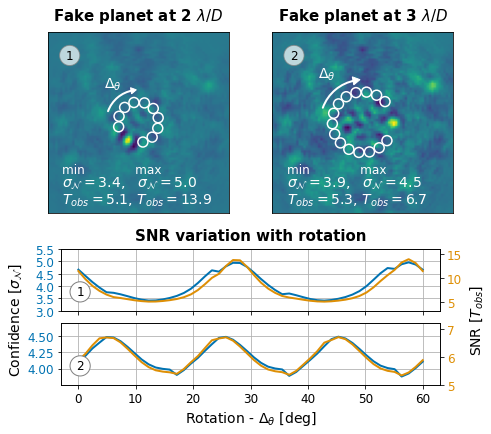

In [14]:
# 1.) Create the figure layout using gridspec ---------------------------------------------
fig = plt.figure(constrained_layout=False, figsize=(8, 10))
gs0 = fig.add_gridspec(2, 1, height_ratios= [3, 1.])
gs0.update(hspace=0.31,)

gs0a = gridspec.GridSpecFromSubplotSpec(2, 1, 
                                        subplot_spec=gs0[0],
                                        hspace=0.23,
                                        height_ratios= [2, 1.5])

# Residuals plots
gs01 = gridspec.GridSpecFromSubplotSpec(1, 2, 
                                        subplot_spec=gs0a[0],
                                        wspace=0.01)

residual_ax1 = fig.add_subplot(gs01[0])
residual_ax2 = fig.add_subplot(gs01[1])

# SNR variation plots
gs02 = gridspec.GridSpecFromSubplotSpec(2, 3, 
                                        width_ratios=[0.02, 1, 0.02],
                                        subplot_spec=gs0a[1])

snr_var_ax1 = fig.add_subplot(gs02[0, 1])
snr_var_ax2 = fig.add_subplot(gs02[1, 1], sharex=snr_var_ax1)

# 2.) Plot the residuals with aperture positions --------------------------------------------
plot_residual(residual_ax1, planet_position_1, planet_residual_1)

residual_ax1.set_title(
    r"Fake planet at 2 $\lambda /D$", 
    fontsize=15, fontweight="bold", y=1.03)

add_residual_labels(residual_ax1, "1", min_p_1, max_p_1, min_t_1, max_t_1)



plot_residual(residual_ax2, planet_position_2, planet_residual_2)
residual_ax2.set_title(
    r"Fake planet at 3 $\lambda /D$", 
    fontsize=15, fontweight="bold", y=1.03)

add_residual_labels(residual_ax2, "2", min_p_2, max_p_2, min_t_2, max_t_2)

# 3.) Plot the SNR, detection confidence variation ----------------------------------------------
# Subplot 1
snr_var_ax1.plot(
    np.linspace(0, 60, len(p_values_sigma_1)), 
    p_values_sigma_1,
    color = color_palette[0], lw=2)

snr_var_ax1.tick_params(axis='y', labelcolor=color_palette[0])
snr_var_ax1.tick_params(axis='both', which='major', labelsize=12)
snr_var_ax1.set_ylim(3., 5.5)
snr_var_ax1.set_yticks([3., 3.5, 4., 4.5, 5., 5.5])

snr_var_ax1_twin = snr_var_ax1.twinx()
snr_var_ax1_twin.plot(
    np.linspace(0, 60, len(p_values_sigma_1)),
    t_values_1,
    color = color_palette[1], lw=2)

snr_var_ax1_twin.tick_params(axis='y', labelcolor=color_palette[1])
snr_var_ax1_twin.tick_params(axis='both', which='major', labelsize=12)
snr_var_ax1_twin.set_ylim(3.2, 16.)


snr_var_ax1.grid()
plt.setp(snr_var_ax1.get_xticklabels(), visible=False)
snr_var_ax1.set_title(r"SNR variation with rotation",
                      fontsize=15, fontweight="bold", y=1.05)

fig.text(0.09, 0.48,
         r"Confidence [$\sigma_{\mathcal{N}}$]",
         va="center",
         rotation='vertical', fontsize=14)

fig.text(0.89, 0.48,
         r"SNR [$T_{obs}$]",
         va="center",
         rotation='vertical', fontsize=14)

# Subplot 2
snr_var_ax2.plot(
    np.linspace(0, 60, len(p_values_sigma_2)),
    p_values_sigma_2,
    color = color_palette[0], lw=2)

snr_var_ax2.tick_params(axis='y', labelcolor=color_palette[0])
snr_var_ax2.tick_params(axis='both', which='major', labelsize=12)

snr_var_ax2.set_ylim(3.75, 4.7)
snr_var_ax2.set_yticks([4., 4.25, 4.5])

snr_var_ax2_twin = snr_var_ax2.twinx()
snr_var_ax2_twin.plot(
    np.linspace(0, 60, len(t_values_2)),
    t_values_2,
    color = color_palette[1], lw=2)

snr_var_ax2_twin.tick_params(axis='y', labelcolor=color_palette[1])
snr_var_ax2_twin.tick_params(axis='both', which='major', labelsize=12)
snr_var_ax2_twin.set_ylim(5., 7.2)

snr_var_ax2.grid()
snr_var_ax2.set_xlabel(r"Rotation - $\Delta_{\theta}$ [deg]", size=14)


snr_var_ax1_twin.text(0.05, 0.25, "1",
                 ha="center", fontsize=12, transform = snr_var_ax1.transAxes,
                 bbox={"fc":"white", "ec":"grey","boxstyle":"circle" })

snr_var_ax2_twin.text(0.05, 0.25, "2",
                 ha="center", fontsize=12, transform = snr_var_ax2.transAxes,
                 bbox={"fc":"white", "ec":"grey","boxstyle":"circle" })

# Save the plot
fig.patch.set_facecolor('white')
plt.savefig("./02_Rotation.pdf", bbox_inches='tight')